# Baseline Evaluation

This notebook evaluates baseline retrieval methods (BM25 and TF-IDF) on TREC-COVID and Climate-Fever datasets.

## How to Run

1. Press "Run All" to execute all cells
2. All required files will be created automatically if missing
3. Results will be saved to `data/eval/metric/baseline/`
4. Plots will be saved to `data/eval/plot/baseline/`


In [1]:
# Setup: imports and path configuration
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Notebook is located at notebook/eval/baseline.ipynb
project_root = Path.cwd().parents[1]

# Define core configuration
datasets = ["trec_covid", "climate_fever"]
retrieval_methods = ["bm25"]  # baseline retrieval methods we actually support
data_base = project_root / "data"

sys.path.insert(0, str(project_root / 'src'))

from eval import (
    compute_metrics_from_files,
    save_metrics_to_csv,
    load_run_file,
    load_qrels_file,
    compute_per_query_metric,
    compare_runs,
)
from eval.utils import (
    ensure_directory,
    create_summary_table,
)
from notebook.run_api import ensure_baseline_runs
from ingest.api import prepare as ingest_prepare, download as ingest_download, ingest as ingest_dataset
from index.tokenize import tokenize_corpus

print("Setup complete! Project root:", project_root)


Setup complete! Project root: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms


c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\.venv\Lib\site-packages\beir\datasets\data_loader.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Ensure ingest outputs and baseline runs

Use the programmatic ingest + retrieval API to materialize real artifacts under data/ingest/{dataset} and data/retrieval/baseline/ if they are missing.


In [2]:
# Ensure output directories exist
ensure_directory(data_base / "retrieval" / "baseline")
ensure_directory(data_base / "eval" / "metric" / "baseline")
ensure_directory(data_base / "eval" / "plot")
ensure_directory(data_base / "eval" / "slice")

# Ensure ingest artifacts + baseline runs (BM25) exist
runs = ensure_baseline_runs(datasets=datasets, retrieval_methods=retrieval_methods, top_k=100)
print("Baseline runs ensured:\n", json.dumps(runs, indent=2, default=str))

=== Dataset: trec_covid ===
[trec_covid] Extracted dataset is stale (newer download found); will re-extract.
[trec_covid] Re-extracting from existing download...


Failed to download trec_covid: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\data\\download\\trec-covid.zip' -> 'C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\data\\download\\trec_covid.zip'


Loaded pre-tokenized data for faster BM25 retrieval
[trec_covid / bm25] Running BM25 baseline...
Building BM25 index...


Retrieving results...



Processing queries:   0%|          | 0/50 [00:00<?, ?it/s]


Processing queries:   2%|▏         | 1/50 [00:01<00:54,  1.12s/it]


Processing queries:   4%|▍         | 2/50 [00:01<00:45,  1.05it/s]


Processing queries:   6%|▌         | 3/50 [00:02<00:44,  1.06it/s]


Processing queries:   8%|▊         | 4/50 [00:03<00:35,  1.29it/s]


Processing queries:  10%|█         | 5/50 [00:04<00:38,  1.17it/s]


Processing queries:  12%|█▏        | 6/50 [00:05<00:38,  1.15it/s]


Processing queries:  14%|█▍        | 7/50 [00:06<00:40,  1.07it/s]


Processing queries:  16%|█▌        | 8/50 [00:07<00:44,  1.07s/it]


Processing queries:  18%|█▊        | 9/50 [00:08<00:37,  1.11it/s]


Processing queries:  20%|██        | 10/50 [00:12<01:20,  2.00s/it]


Processing queries:  22%|██▏       | 11/50 [00:31<04:35,  7.06s/it]


Processing queries:  24%|██▍       | 12/50 [00:33<03:37,  5.72s/it]


Processing queries:  26%|██▌       | 13/50 [00:34<02:35,  4.21s/it]


Processing queries:  28%|██▊       | 14/50 [00:35<01:55,  3.21s/it]


Processing queries:  30%|███       | 15/50 [00:36<01:32,  2.65s/it]


Processing queries:  32%|███▏      | 16/50 [00:38<01:17,  2.28s/it]


Processing queries:  34%|███▍      | 17/50 [00:43<01:47,  3.26s/it]


Processing queries:  36%|███▌      | 18/50 [00:46<01:37,  3.05s/it]


Processing queries:  38%|███▊      | 19/50 [00:50<01:47,  3.46s/it]


Processing queries:  40%|████      | 20/50 [00:51<01:22,  2.76s/it]


Processing queries:  42%|████▏     | 21/50 [00:53<01:06,  2.29s/it]


Processing queries:  44%|████▍     | 22/50 [00:56<01:15,  2.70s/it]


Processing queries:  46%|████▌     | 23/50 [01:17<03:37,  8.06s/it]


Processing queries:  48%|████▊     | 24/50 [01:27<03:43,  8.59s/it]


Processing queries:  50%|█████     | 25/50 [01:28<02:42,  6.51s/it]


Processing queries:  52%|█████▏    | 26/50 [01:30<01:59,  4.98s/it]


Processing queries:  54%|█████▍    | 27/50 [01:33<01:43,  4.51s/it]


Processing queries:  56%|█████▌    | 28/50 [01:35<01:24,  3.83s/it]


Processing queries:  58%|█████▊    | 29/50 [01:40<01:23,  3.96s/it]


Processing queries:  60%|██████    | 30/50 [01:41<01:00,  3.04s/it]


Processing queries:  62%|██████▏   | 31/50 [01:42<00:46,  2.47s/it]


Processing queries:  64%|██████▍   | 32/50 [01:43<00:39,  2.18s/it]


Processing queries:  66%|██████▌   | 33/50 [01:44<00:30,  1.77s/it]


Processing queries:  68%|██████▊   | 34/50 [01:45<00:26,  1.64s/it]


Processing queries:  70%|███████   | 35/50 [02:04<01:42,  6.84s/it]


Processing queries:  72%|███████▏  | 36/50 [02:06<01:13,  5.25s/it]


Processing queries:  74%|███████▍  | 37/50 [02:07<00:52,  4.04s/it]


Processing queries:  76%|███████▌  | 38/50 [02:08<00:38,  3.17s/it]


Processing queries:  78%|███████▊  | 39/50 [02:09<00:27,  2.54s/it]


Processing queries:  80%|████████  | 40/50 [02:11<00:23,  2.32s/it]


Processing queries:  82%|████████▏ | 41/50 [02:13<00:18,  2.11s/it]


Processing queries:  84%|████████▍ | 42/50 [02:14<00:14,  1.75s/it]


Processing queries:  86%|████████▌ | 43/50 [02:15<00:11,  1.63s/it]


Processing queries:  88%|████████▊ | 44/50 [02:16<00:09,  1.54s/it]


Processing queries:  90%|█████████ | 45/50 [02:17<00:07,  1.42s/it]


Processing queries:  92%|█████████▏| 46/50 [02:23<00:11,  2.78s/it]


Processing queries:  94%|█████████▍| 47/50 [02:39<00:19,  6.60s/it]


Processing queries:  96%|█████████▌| 48/50 [02:43<00:11,  5.76s/it]


Processing queries:  98%|█████████▊| 49/50 [02:45<00:04,  4.76s/it]


Processing queries: 100%|██████████| 50/50 [02:46<00:00,  3.66s/it]


Processing queries: 100%|██████████| 50/50 [02:46<00:00,  3.34s/it]

[trec_covid / bm25] Saved baseline run to C:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\retrieval\baseline\bm25_trec_covid.csv
=== Dataset: climate_fever ===
[climate_fever] All requested baseline runs valid; skipping all upstream work.


Baseline runs ensured:
 {
  "trec_covid": {
    "bm25": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\data\\retrieval\\baseline\\bm25_trec_covid.csv"
  },
  "climate_fever": {
    "bm25": "C:\\Users\\Lenovo\\CodeProjects\\VSC\\domain-specific-query-expansion-with-llms\\data\\retrieval\\baseline\\bm25_climate_fever.csv"
  }
}


## Load and display dataset statistics

In [3]:
# Load and display dataset statistics from manifest.json
print("\n=== Dataset Statistics ===")
from ingest.core import get_ingested_dataset_paths

dataset_stats = {}
for dataset in datasets:
    paths = get_ingested_dataset_paths(dataset)
    if paths.manifest.exists():
        manifest_data = json.loads(paths.manifest.read_text(encoding="utf-8"))
        dataset_stats[dataset] = {
            "doc_count": manifest_data.get("doc_count", "N/A"),
            "query_count": manifest_data.get("query_count", "N/A"),
            "qrels_count": manifest_data.get("qrels_count", "N/A"),
            "vocab_size": manifest_data.get("vocab_size", "N/A"),
            "split": manifest_data.get("split", "N/A"),
        }
        print(f"{dataset}:")
        print(f"  Documents: {dataset_stats[dataset]['doc_count']}")
        print(f"  Queries: {dataset_stats[dataset]['query_count']}")
        print(f"  Qrels: {dataset_stats[dataset]['qrels_count']}")
        print(f"  Vocab size: {dataset_stats[dataset]['vocab_size']}")
        print(f"  Split: {dataset_stats[dataset]['split']}")

# Save dataset statistics to data/eval
if dataset_stats:
    stats_path = data_base / "eval" / "dataset_stats.json"
    ensure_directory(stats_path.parent)
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(dataset_stats, f, indent=2)
    print(f"\nDataset statistics saved to: {stats_path}")


=== Dataset Statistics ===
trec_covid:
  Documents: 171332
  Queries: 50
  Qrels: 66336
  Vocab size: 50000
  Split: test
climate_fever:
  Documents: 5416593
  Queries: 1535
  Qrels: 4681
  Vocab size: 50000
  Split: test

Dataset statistics saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\dataset_stats.json


## Compute Metrics for All 4 Combos

Compute nDCG@10, MAP, Recall@100, MRR for:
- BM25 × TREC-COVID
- BM25 × Climate-Fever  
- TF-IDF × TREC-COVID
- TF-IDF × Climate-Fever


In [4]:
# Compute metrics for all combinations using real ingest outputs
datasets = ["trec_covid", "climate_fever"]
all_metrics = {}

for dataset in datasets:
    qrels_path = data_base / "ingest" / dataset / "qrels.csv"

    for retrieval in retrieval_methods:
        run_path = data_base / "retrieval" / "baseline" / f"{retrieval}_{dataset}.csv"
        metric_path = data_base / "eval" / "metric" / "baseline" / f"{retrieval}_{dataset}.csv"

        # Compute and save metrics
        metrics = compute_metrics_from_files(str(run_path), str(qrels_path), k=10)
        save_metrics_to_csv(
            metrics,
            str(metric_path),
            dataset=dataset,
            method="baseline",
            retrieval=retrieval,
        )

        all_metrics[(dataset, "baseline", retrieval)] = metrics

print("\nMetrics computation complete!")


Metrics computation complete!


## Summary Table


In [5]:
# Create and display summary table
summary_df = create_summary_table(all_metrics)
summary_path = data_base / "eval" / "metric" / "baseline" / "summary.csv"
summary_df.to_csv(summary_path, index=False)

print("Summary Metrics Table:")
print(summary_df.to_string(index=False))
print(f"\nSaved to: {summary_path}")


Summary Metrics Table:
      dataset   method retrieval  ndcg@10      map  recall@100      mrr
   trec_covid baseline      bm25 0.364900 0.368874    0.055457 0.600733
climate_fever baseline      bm25 0.137596 0.163912    0.361846 0.197883

Saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\metric\baseline\summary.csv


## Plot nDCG@10 Comparison


Plot saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\plot\baseline_ndcg_bm25.png


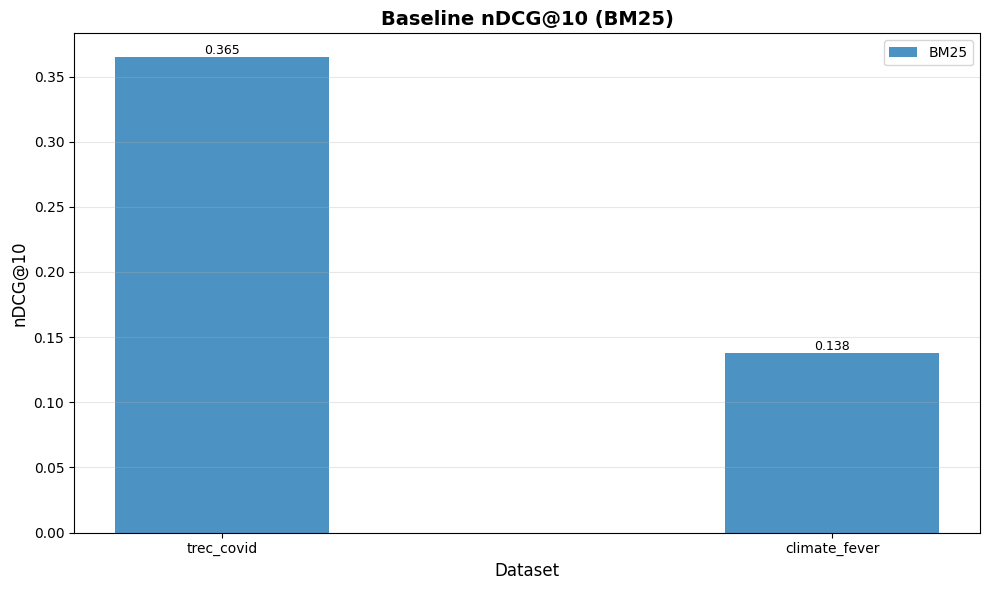

In [ ]:
# Plot nDCG@10 comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(datasets))
width = 0.35

bm25_scores = [all_metrics[(d, "baseline", "bm25")]["ndcg@10"] for d in datasets]

bars1 = ax.bar(x, bm25_scores, width, label="BM25", alpha=0.8)

ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("nDCG@10", fontsize=12)
ax.set_title("Baseline nDCG@10 (BM25)", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{height:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

# Save plot
# TODO: data/eval/plot/{method}_ndcg.png (contains 2 datasets x 2 retrievals)
plot_path = data_base / "eval" / "plot" / "baseline_ndcg_bm25.png"
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Plot saved to: {plot_path}")
plt.show()


## Robustness Analysis: Compute Query Slices


In [7]:
# Compute query slices for each dataset using ingest outputs (queries + vocab)
from eval.robustness_slices import compute_query_slices, load_vocabulary

for dataset in datasets:
    run_path = data_base / "retrieval" / "baseline" / f"bm25_{dataset}.csv"
    vocab_path = data_base / "ingest" / dataset / "vocab_top50k.txt"
    queries_path = data_base / "ingest" / dataset / "queries.csv"
    slices_path = data_base / "eval" / "slice" / f"{dataset}.csv"

    # Load vocabulary
    vocab = load_vocabulary(str(vocab_path), top_n=50000)

    # Load queries.csv (query_id,text,split)
    queries_df = pd.read_csv(queries_path)
    # Convert query_id to string to match run file format
    queries = {str(row["query_id"]): row["text"] for _, row in queries_df.iterrows()}

    # Compute slices
    slices = compute_query_slices(
        queries,
        str(run_path),
        vocab=vocab,
        output_file=str(slices_path),
    )

    familiar = sum(1 for s in slices.values() if s["label"] == "familiar")
    unfamiliar = len(slices) - familiar

    print(f"{dataset}: {familiar} familiar, {unfamiliar} unfamiliar queries")
    print(f"Slices saved to: {slices_path}")

print("\nRobustness analysis complete!")


trec_covid: 50 familiar, 0 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\slice\trec_covid.csv


climate_fever: 1534 familiar, 1 unfamiliar queries
Slices saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\data\eval\slice\climate_fever.csv

Robustness analysis complete!
